#CafChem tools for fitting Dense Neural Network models to a dataset. Includes regression and classification.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/CafChem/blob/main/notebooks/SkipDense_CafChem.ipynb)

## This notebook allows you to:
- Upload a dataset, and, optionally, create classes.
- Scale, apply PCA and split your dataset.
- Train a regression or classification model and evaluate it.
- Save and load models.
- Serve predictions with a new or loaded model.

## A Skipdense block is ...
- a block with a specified number of dense neural network layers and an optional skip-connection from the input to the output.
- multiple skipdense blocks may be stacked.

## Requirements:
- This notebook will install deepchem and Mordred
- It will pull the CafChem tools from Github.
- It will install all needed libraries.
- Can use a CPU runtime for traininf and inference on a small model. Any GPU recommended for larger models

## Set Up

### Install libraries

In [1]:
! pip install deepchem
! pip install mordred

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 114.2 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176718 sha256=706d0622139271a57250033f0d32089f2b4ef7dec1f257d5bcbfcd90065a8cb8
  Stored in directory: /root/.cache/pip/wheels/8b/30/0b/84e3f6775306e74cf5957ee4d16b10bf3927dcec44cc23d5f2
Successfully built mordred
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: networkx
    Found existin

### Pull Cafchem from Github and import libraries

In [1]:
!git clone https://github.com/MauricioCafiero/CafChem.git

Cloning into 'CafChem'...
remote: Enumerating objects: 535, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 535 (delta 93), reused 45 (delta 45), pack-reused 423 (from 1)
Receiving objects: 100% (535/535), 39.87 MiB | 16.70 MiB/s, done.
Resolving deltas: 100% (311/311), done.


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import MolsToGridImage
import matplotlib.pyplot as plt
import pickle

import CafChem.CafChemSkipDense as ccsd

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## Regression

### Load Data
- Use Pandas to lead your dataset and prepare a SMILES list and a target list. Apply transformations if needed.
- Send lists to the Featurize tool to featurize with RDKit, Mordred or Fingerprints.
- Apply scaling and PCA if needed and split the datastet. *NOTE:* Scaling is not needed for this NN as it uses internal normalization.
- Outlier removal also provided. For regression you can remove outlier based on either the features or target data. For classification, only features should be used.

In [3]:
df = pd.read_csv("/content/905-unique-statins.csv")
df.head()

,Unnamed: 0,Ligand SMILES,IC50 (nM)
0,7,[Na+].CC(C)c1c(\C=C\[C@H](O)C[C@@H](O)CC([O-])...,0.106
1,8,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.200
2,10,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.300
3,11,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c2C...,0.300
4,12,COC(=O)C[C@H](O)C[C@H](O)\C=C\n1c(C(C)C)c(Br)c...,0.300


In [4]:
smiles = df["Ligand SMILES"].to_list()
targets = df['IC50 (nM)'].to_list()

targets = [np.log10(x) for x in targets]

In [5]:
x, y, Xa = ccsd.featurize(smiles, targets, featurizer = "rdkit", classifier_flag=False)

Old dimensions are: (905, 217).
New dimensions are: (905, 217)


In [6]:
X_train, X_valid, y_train, y_valid, smiles_train, smiles_valid, pca, scaler = ccsd.scale_pca_split(x,y,Xa, False, False)

Pre-processing done.


### Set model and train
- Create a skipdense_model class and set number layers per Skipdense block, number of neurons per layer, number of blocks, whether each block should include a skip connection or not, learning rate and regularization constant.
  * for classifiation models, specify the classification_flag as True and include the number of classes.
  * for training, specify epochs and batch_size
- Once the class is instantiated, build_model and then train_model. Afterwards you can eval_model.
- Examples given below to save a model and load a model.

In [7]:
skip = ccsd.skipdense_model(ntlu = 400, epochs = 50, skip = [True, False])

skipdense model initialized!


In [8]:
model = skip.build_model(X_train)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 217)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 217)            │           435 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ skip_dense_block                │ (None, 617)            │       568,400 │
│ (SkipDenseBlock)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ skip_dense_block_1              │ (None, 1017)           │       728,400 │
│ (SkipDenseBlock)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │         1,018 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,298,253 (4.95 MB)

 Trainable params: 1,297,818 (4.95 MB)

 Non-trainable params: 435 (1.70 KB)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 217))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 217))
  warnings.warn(msg)


13/13 - 6s - 481ms/step - loss: 10.4348 - val_loss: 1.8936 - learning_rate: 0.0020
Epoch 2/50
13/13 - 2s - 121ms/step - loss: 1.8524 - val_loss: 2.0165 - learning_rate: 0.0019
Epoch 3/50
13/13 - 0s - 17ms/step - loss: 1.7773 - val_loss: 1.3326 - learning_rate: 0.0018
Epoch 4/50
13/13 - 0s - 14ms/step - loss: 1.3116 - val_loss: 1.6153 - learning_rate: 0.0017
Epoch 5/50
13/13 - 0s - 23ms/step - loss: 1.5381 - val_loss: 1.6006 - learning_rate: 0.0017
Epoch 6/50
13/13 - 0s - 15ms/step - loss: 1.3078 - val_loss: 1.3429 - learning_rate: 0.0016
Epoch 7/50
13/13 - 0s - 23ms/step - loss: 1.3757 - val_loss: 1.3326 - learning_rate: 0.0015
Epoch 8/50
13/13 - 0s - 14ms/step - loss: 1.5234 - val_loss: 1.3586 - learning_rate: 0.0014
Epoch 9/50
13/13 - 0s - 14ms/step - loss: 1.2041 - val_loss: 1.1377 - learning_rate: 0.0014
Epoch 10/50
13/13 - 0s - 23ms/step - loss: 1.1675 - val_loss: 1.2560 - learning_rate: 0.0013
Epoch 11/50
13/13 - 0s - 23ms/step - loss: 1.1806 - val_loss: 1.3185 - learning_rate: 0

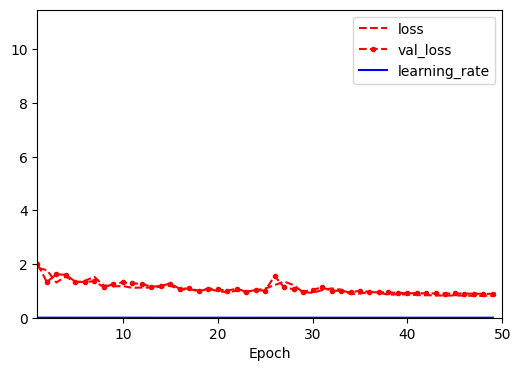

In [11]:
model, df = skip.train_model(model, X_train, y_train, X_valid, y_valid)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 217))
  warnings.warn(msg)


 1/26 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 217))
  warnings.warn(msg)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Training set score is [0.75482909], validation set score is [0.72012059]


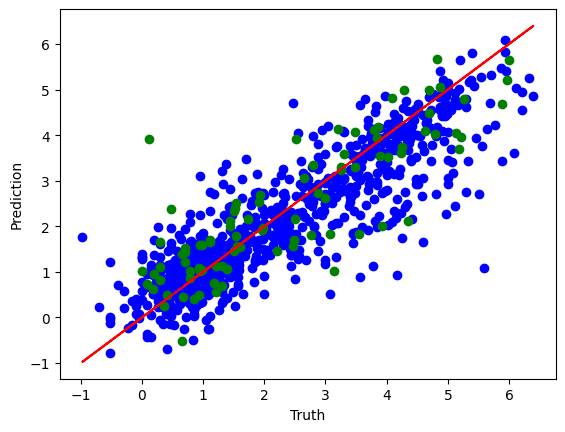

In [12]:
skip.eval_model(model, X_train, y_train, X_valid, y_valid)

In [13]:
skip.save_model(model, "skip_test")

Paramters and weights saved to the Checks/ folder!


In [15]:
model_class, new_model = ccsd.load_model("skip_test", X_train)

skipdense model initialized!


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 217)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 217)            │           435 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ skip_dense_block_2              │ (None, 617)            │       568,400 │
│ (SkipDenseBlock)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ skip_dense_block_3              │ (None, 1017)           │       728,400 │
│ (SkipDenseBlock)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │         1,018 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,298,253 (4.95 MB)

 Trainable params: 1,297,818 (4.95 MB)

 Non-trainable params: 435 (1.70 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_7']
Received: inputs=Tensor(shape=(32, 217))
  warnings.warn(msg)


 1/26 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_7']
Received: inputs=Tensor(shape=(None, 217))
  warnings.warn(msg)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Training set score is [0.75482909], validation set score is [0.72012059]


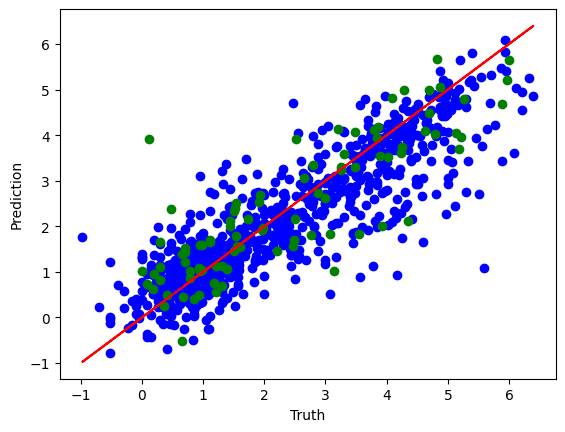

In [16]:
model_class.eval_model(new_model, X_train, y_train, X_valid, y_valid)

## Classification

### Load data
- Send a CSV with quantitative data to the make_classes tool to create a specified number of classes.
- Featurize with the classifier_flag=True.
- Apply scaling (not really needed for these Neural Networks), apply PCA and split the dataset.

In [17]:
df, class_names = ccsd.make_classes("/content/905-unique-statins.csv", "IC50 (nM)", 3)

Samples per class: 301, total samples:905


In [18]:
class_names

['0.106 < 15.0', '15.0 < 1000.0', '1000.0 < 2488000.0']

In [19]:
smiles = df["Ligand SMILES"].to_list()
targets = df["target"].to_list()

In [20]:
f, y, Xa = ccsd.featurize(smiles, targets, featurizer = "rdkit", classifier_flag=True)

Old dimensions are: (905, 217).
New dimensions are: (905, 217)


In [21]:
y.shape

(905, 3)

In [23]:
X_train, X_valid, y_train, y_valid, smiles_train, smiles_valid, pca, scaler = ccsd.scale_pca_split(f,y,Xa, False, False)

Pre-processing done.


## Set model and train
- Define a skipdense class with classifier_flag= Triue and the number fo classes
- build_model and train_model.
- See the examples to use argmax to convert the targets and predictions to the correct format for evaluation.
- Use a confusion matrix to visualize the results.
- See example to use prediction for classifiers.

In [24]:
skip = ccsd.skipdense_model(ntlu = 400, epochs = 50, skip = [True, False], classifier_flag = True, num_classes = 3)

skipdense model initialized!


In [25]:
model = skip.build_model(X_train)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 217)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_2 (Normalization) │ (None, 217)            │           435 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ skip_dense_block_4              │ (None, 617)            │       568,400 │
│ (SkipDenseBlock)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ skip_dense_block_5              │ (None, 1017)           │       728,400 │
│ (SkipDenseBlock)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │         3,054 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,300,289 (4.96 MB)

 Trainable params: 1,299,854 (4.96 MB)

 Non-trainable params: 435 (1.70 KB)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_14']
Received: inputs=Tensor(shape=(None, 217))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_14']
Received: inputs=Tensor(shape=(None, 217))
  warnings.warn(msg)


13/13 - 9s - 694ms/step - accuracy: 0.3170 - loss: 63.2405 - val_accuracy: 0.3407 - val_loss: 14.1518 - learning_rate: 0.0020
Epoch 2/50
13/13 - 4s - 302ms/step - accuracy: 0.3550 - loss: 8.6922 - val_accuracy: 0.3846 - val_loss: 5.4502 - learning_rate: 0.0019
Epoch 3/50
13/13 - 0s - 22ms/step - accuracy: 0.4373 - loss: 4.1910 - val_accuracy: 0.5055 - val_loss: 3.2439 - learning_rate: 0.0018
Epoch 4/50
13/13 - 0s - 24ms/step - accuracy: 0.4754 - loss: 3.5079 - val_accuracy: 0.5055 - val_loss: 3.0975 - learning_rate: 0.0017
Epoch 5/50
13/13 - 0s - 21ms/step - accuracy: 0.4914 - loss: 3.0601 - val_accuracy: 0.5495 - val_loss: 3.0977 - learning_rate: 0.0017
Epoch 6/50
13/13 - 0s - 15ms/step - accuracy: 0.5258 - loss: 2.9876 - val_accuracy: 0.5385 - val_loss: 2.9429 - learning_rate: 0.0016
Epoch 7/50
13/13 - 0s - 24ms/step - accuracy: 0.5418 - loss: 2.7555 - val_accuracy: 0.5275 - val_loss: 2.8315 - learning_rate: 0.0015
Epoch 8/50
13/13 - 0s - 23ms/step - accuracy: 0.5725 - loss: 2.6226 -

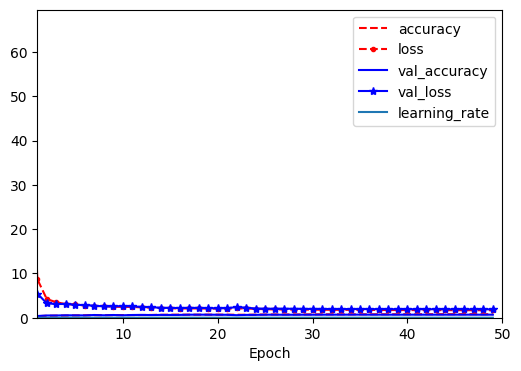

In [26]:
model, df = skip.train_model(model, X_train, y_train, X_valid, y_valid)

In [27]:
preds = np.argmax(model.predict(X_valid),axis=1)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_14']
Received: inputs=Tensor(shape=(32, 217))
  warnings.warn(msg)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_14']
Received: inputs=Tensor(shape=(None, 217))
  warnings.warn(msg)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step


In [28]:
truths = np.argmax(y_valid,axis=1)

In [30]:
eval = ccsd.evaluate(model, class_names, X_valid, y_valid)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


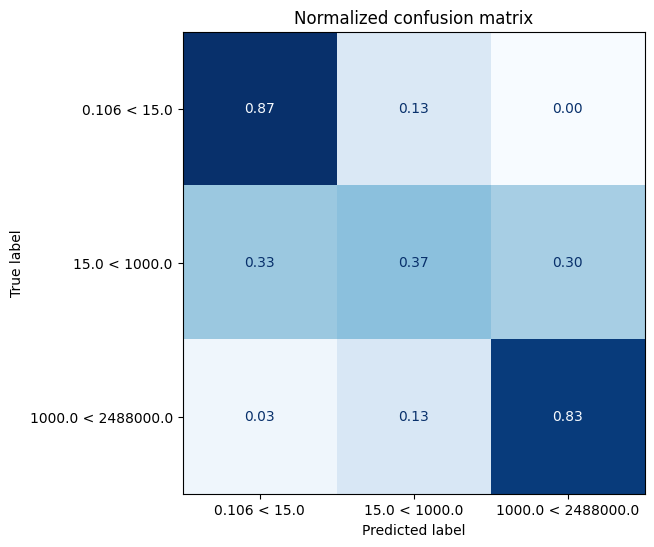

In [31]:
eval.confusion()

In [33]:
test_smile = "c1ccc(F)cc1"

pred_test = ccsd.predict_with_model([test_smile], model, featurizer="rdkit")
pred_result = np.argmax(pred_test,axis=1)
print(class_names[pred_result[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1000.0 < 2488000.0
